In [1]:
using FEM, Potential, PyPlot, Printf, JLD

### Part 1: Get collocation points and integration kernel for whole domain

In [2]:
Nh = 64    # The number of Spectral element
Np = 4     # The order of polynomial which used to interpolate and integration

# Define Physical Domain
xratio = 1 # unit: dimensionless
xavg = 1   # unit: dimensionless

x, w, Ldx, L = getLagrange(Np, xratio/Nh)
e_norm = x[end] - x[1]
interpo_xs = x .+ x[end]

N, xref, w0, Ldx, w = get_fem_xref_weights_basis(Nh, Np, xratio, xavg);

### Part 2: Set $V(x)$ and $p_{eq}(x)$ for simulation

In [3]:
k_ref = 247.15 # unit: dimensionless
Vref = harmonic_well_k_mean(xref, k_ref, xavg)
rho_eq = get_rhoeq(Vref, w0);

### Part 3: Langenvin dynamics simulations

In [11]:
# physical parameters
save_freq = 1e-2 # unit: s, Save trajectory per 10e-3 s
total_times = 100 # unit: s, totol simulate 10 s
dt = 1e-5 # unit: s  # Integration Times 1ps
D = 1; # Diffusion coefficient, unit: s-1
tau = Int(round(total_times / save_freq, digits=0))  # Number of photons
n_interval = Int(round(save_freq / dt, digits=0));

time_info = @sprintf "Save trajectory per %d timesteps. There will be %d data points." n_interval tau
println(time_info)

Save trajectory per 1000 timesteps. There will be 10000 data points.


In [12]:
# Initialize Variables
y_record = zeros(tau+1, 1)  # In HMM, observing variables Y(t)
t_record = zeros(tau+1, 1)

ypos = xavg # Initial Position, from mean position
t = 0

# Simulation Start
for tau_id = 1:tau
    y_record[tau_id] = ypos
    t_record[tau_id] = t
    for i = 1:n_interval
        F = force_harmonic_well_k_mean(ypos, k_ref, xavg)
        ypos = ypos + D*dt*F + (dt*2*D)^(1/2) * randn()
        t += dt   
    end
end
y_record[tau+1] = ypos
t_record[tau+1] = t;

### Part 4: Save trajectory or Read trajectory

In [13]:
# Save simulated trajectory to jld file
f_out = "/home/yizaochen/codes/julia/md_pisl/trajectory/harmonic_dimensionless_2.jld"
save(f_out, "y_record", y_record, "t_record", t_record, "xref", xref, "rho_eq", rho_eq, "D", D, "k_ref", k_ref)

In [21]:
# Read simulated trajectory from jld file
f_in = "/home/yizaochen/codes/julia/md_pisl/trajectory/harmonic_dimensionless.jld"
y_record = load(f_in, "y_record")
t_record = load(f_in, "t_record")
xref = load(f_in, "xref")
rho_eq = load(f_in, "rho_eq")
k_ref = load(f_in, "k_ref")
D = load(f_in, "D");

### Part 5: Plot

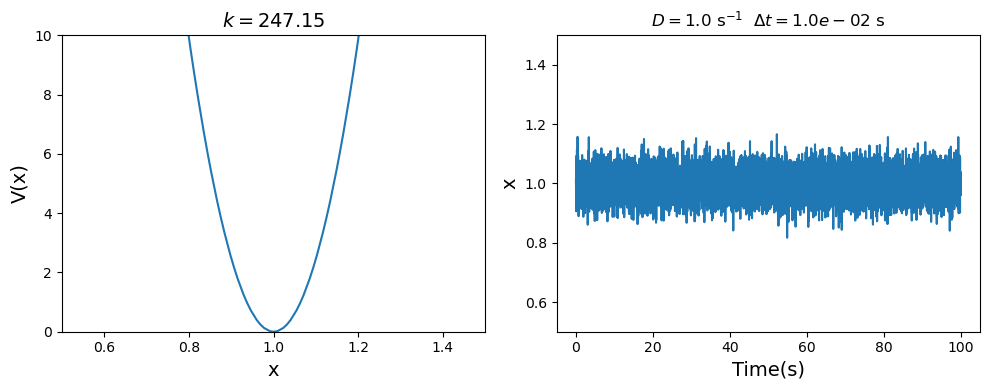

In [14]:
lbfz = 14
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10,4))

ax = axes[1]
ax.plot(xref, Vref)
ax.set_xlabel("x", fontsize=lbfz)
ax.set_ylabel("V(x)", fontsize=lbfz)
title = @sprintf "\$ k=%.2f \$" k_ref
ax.set_title(title, fontsize=lbfz)
ax.set_ylim(0, 10)
ax.set_xlim(0.5, 1.5)

ax = axes[2]
ax.plot(t_record, y_record)
ax.set_ylabel("x", fontsize=lbfz)
ax.set_xlabel("Time(s)", fontsize=lbfz)
title = @sprintf "\$ D=%.1f~\\mathrm{s}^{-1}~~\\Delta t=%.1e~\\mathrm{s}\$" D save_freq
ax.set_title(title)
ax.set_ylim(0.5, 1.5)

plt.tight_layout()
#plt.savefig("V_harmonic_dimensionless.png", dpi=150)
plt.show()